
---
#### *Introduction*
In this notebook, we aim to evaluate the robustness of our pre-trained coin classification model by testing it on images from a third class, `al-Mahdiyah`, which was not part of the original training set. Specifically, we will:
1. **Evaluate Model Performance**: Use the pre-trained model to predict the class of `al-Mahdiyah` images and analyze the classification consistency.
2. **Visualize Model Focus**: Apply Grad-CAM to visualize the regions of the `al-Mahdiyah` images that the model focuses on when making its predictions.
 
The goal is to understand if the `al-Mahdiyah` class shares similarities with the two largest classes (`Misr` and `al-Mansuriyah`) used in the initial training.

---

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils import normalize
import cv2

# Define paths
organized_images_dir = 'Organized_images/al-Mahdiyah'
model_path = 'fine_tuned_vgg16.h5'

### Step 1: Load and Preprocess the Images

In [2]:
# Function to load and preprocess images
def load_and_preprocess_images(image_dir, target_size=(224, 224)):
    image_paths = [os.path.join(image_dir, img_name) for img_name in os.listdir(image_dir)]
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.array(images), image_paths

# Load images and labels for the third class
preprocessed_images, image_paths = load_and_preprocess_images(organized_images_dir)
class_label = 'al-Mahdiyah'
classes = ['Misr', 'al-Mansuriyah']


### Step 2: Load the Pre-trained Model

In [3]:
# Load the pre-trained model
model = load_model(model_path)

In [4]:
# Load and preprocess images
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

### Step 3: Predict and Visualize Grad-CAM

In [8]:
# Function to convert array to image
def array_to_img(array):
    array = array * 255
    array = np.uint8(array)
    img = cv2.cvtColor(array, cv2.COLOR_RGB2BGR)
    return img

# Function to display the heatmap
def display_heatmap(heatmap):
    plt.figure(figsize=(3, 3))
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')
    plt.show()

# Function to superimpose the Grad-CAM heatmap on the original image
def superimpose_heatmap_on_image(img, heatmap, img_path):
    plt.figure(figsize=(3, 3))
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Function to apply post-processing
def apply_post_processing(heatmap, method='gaussian'):
    if method == 'gaussian':
        heatmap = cv2.GaussianBlur(heatmap, (15, 15), 0)
    elif method == 'threshold':
        _, heatmap = cv2.threshold(heatmap, 0.5, 1.0, cv2.THRESH_BINARY)
    return heatmap

# Function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, penultimate_layer='block5_conv3', clone=False, predicted_class=None):
    # Define the score for the target class
    score = CategoricalScore([predicted_class])

    # Generate heatmap
    gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=clone)
    heatmap = gradcam(score, img_array, penultimate_layer=penultimate_layer)
    
    # Normalize the heatmap to keep it in the [0,1] range
    heatmap = normalize(heatmap)
    heatmap = heatmap[0]  # Extract the heatmap for further processing

    # Apply post-processing
    heatmap = apply_post_processing(heatmap)

    return heatmap

 ### Step 4: Predict and Visualize

In [9]:
# Predict and visualize Grad-CAM
predictions = model.predict(preprocessed_images)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


[3.0661788e-26 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


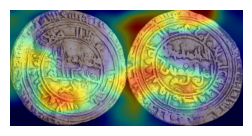

[6.4224615e-32 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


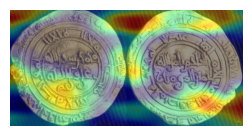

[2.3180252e-26 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


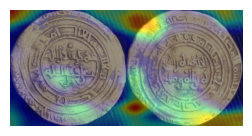

[1.3565006e-16 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


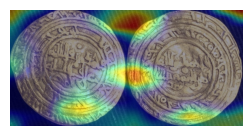

[9.092545e-15 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


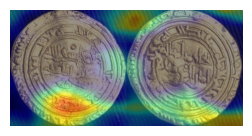

[3.013032e-16 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


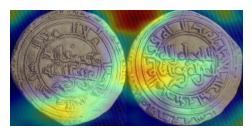

[1.3642588e-16 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


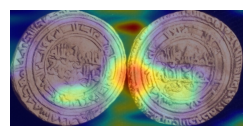

[1.000000e+00 1.130195e-24]
True class: al-Mahdiyah
Predicted class: Misr


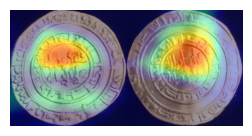

[0. 1.]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


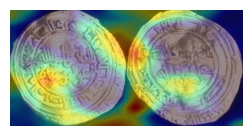

[9.740072e-08 9.999999e-01]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


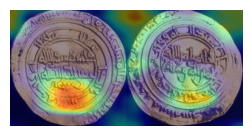

[3.2530486e-22 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


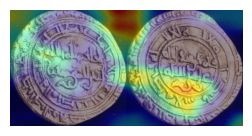

[5.8400856e-27 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


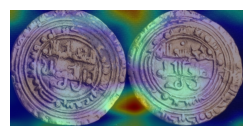

[4.976116e-05 9.999503e-01]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


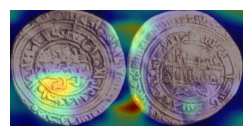

[2.3387684e-23 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


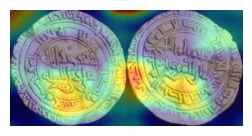

[2.7291863e-34 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


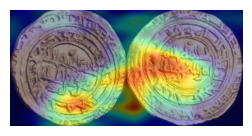

[1.0000000e+00 5.7703465e-21]
True class: al-Mahdiyah
Predicted class: Misr


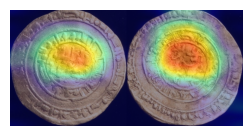

[2.4324308e-27 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


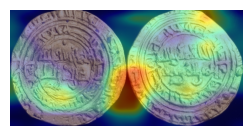

[1.4913909e-04 9.9985087e-01]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


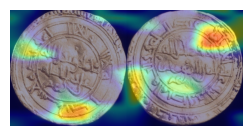

[2.3423087e-19 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


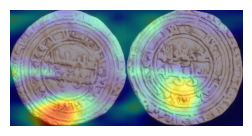

[8.597879e-31 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


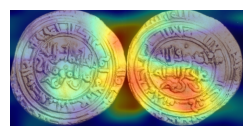

[1.01887444e-25 1.00000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


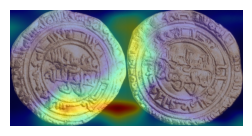

[3.158252e-19 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


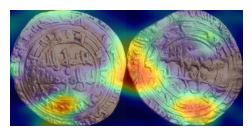

[4.0133383e-27 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


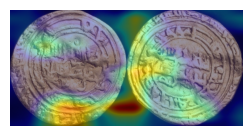

[5.667146e-27 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


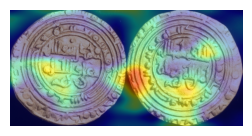

[2.636391e-13 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


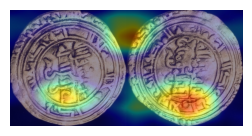

[1.7128398e-19 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


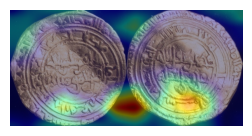

[8.0797e-24 1.0000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


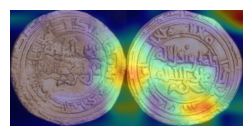

[1.00438775e-25 1.00000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


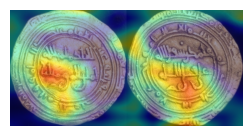

[4.772767e-17 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


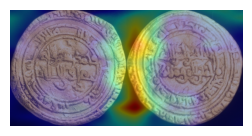

[6.947124e-23 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


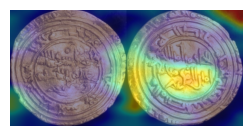

[1.013214e-13 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


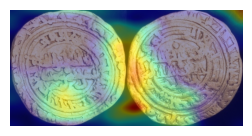

[7.875348e-20 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


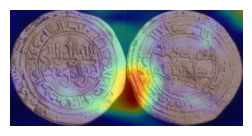

[7.250906e-35 1.000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


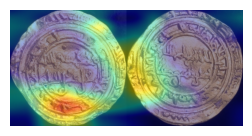

[1.09321024e-16 1.00000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


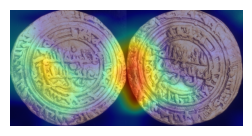

[0.9210373  0.07896264]
True class: al-Mahdiyah
Predicted class: Misr


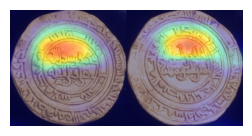

[5.34658e-29 1.00000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


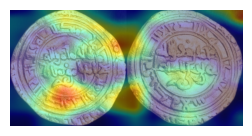

[6.8589394e-37 1.0000000e+00]
True class: al-Mahdiyah
Predicted class: al-Mansuriyah


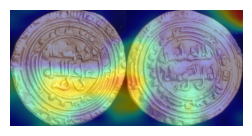

In [10]:
for i, img in enumerate(preprocessed_images):
    print(predictions[i])
    predicted_class = np.argmax(predictions[i])
    print(f"True class: {class_label}")
    print(f"Predicted class: {classes[predicted_class]}")
    heatmap = generate_gradcam_heatmap(model, np.expand_dims(img, axis=0), penultimate_layer='block5_conv3', clone=False, predicted_class=predicted_class)
    superimpose_heatmap_on_image(np.expand_dims(img, axis=0), heatmap, image_paths[i])


### Conclusion
We observed that the model predominantly classifies the `al-Mahdiyah` class images as `al-Mansuriyah` class. This suggests a potential similarity between the `al-Mahdiyah` and `al-Mansuriyah` classes, as perceived by the model. The Grad-CAM visualizations further help in understanding the regions of the images that the model focuses on while making these predictions.

---



Based on the experiment, we observed that the `al-Mahdiyah` images are predominantly being classified as `al-Mansuriyah`.   
In the previous notebook, we found that when the inner part of the coin is removed, the model struggles to correctly classify `al-Mansuriyah` images. 

To further investigate, we will now modify the `al-Mahdiyah` images by removing their inner parts and evaluate if the model continues to classify them as `al-Mansuriyah`.  

In [11]:
modified_images_path = 'modified_images/al-Mahdiyah'

# Load images and labels for the third class
modified_images, modified_images_paths = load_and_preprocess_images(modified_images_path)
class_label = 'al-Mahdiyah'
classes = ['Misr', 'al-Mansuriyah']

In [12]:
# Predict and visualize Grad-CAM
predictions = model.predict(modified_images)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
[0 0 0 0 0 0 0 0 0 0]


[1.0000000e+00 2.1188429e-37]
True class: al-Mahdiyah
Predicted class: Misr


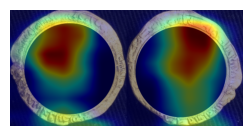

[1. 0.]
True class: al-Mahdiyah
Predicted class: Misr


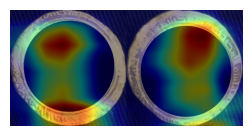

[1.0000000e+00 2.5388793e-34]
True class: al-Mahdiyah
Predicted class: Misr


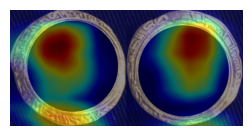

[1. 0.]
True class: al-Mahdiyah
Predicted class: Misr


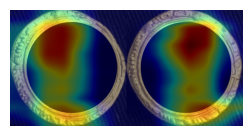

[1. 0.]
True class: al-Mahdiyah
Predicted class: Misr


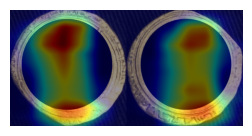

[1. 0.]
True class: al-Mahdiyah
Predicted class: Misr


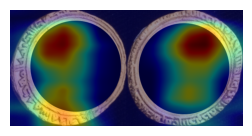

[1. 0.]
True class: al-Mahdiyah
Predicted class: Misr


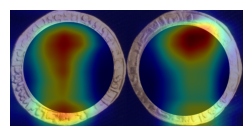

[1.000000e+00 4.601837e-29]
True class: al-Mahdiyah
Predicted class: Misr


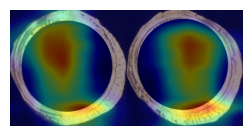

[1. 0.]
True class: al-Mahdiyah
Predicted class: Misr


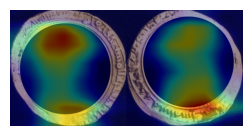

[1. 0.]
True class: al-Mahdiyah
Predicted class: Misr


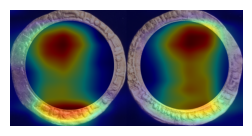

In [13]:
for i, img in enumerate(modified_images):
    print(predictions[i])
    predicted_class = np.argmax(predictions[i])
    print(f"True class: {class_label}")
    print(f"Predicted class: {classes[predicted_class]}")
    heatmap = generate_gradcam_heatmap(model, np.expand_dims(img, axis=0), penultimate_layer='block5_conv3', clone=False, predicted_class=predicted_class)
    superimpose_heatmap_on_image(np.expand_dims(img, axis=0), heatmap, modified_images_paths[i])

**Wow**, the model has predicted all the modified images as the `Misr` class, which is the opposite of its previous predictions. 

We can conclude that for the `al-Mahdiyah` class, the inner part of the coin image is very important for the model's classification.

---